In [1]:
import sqlite3
import pandas as pd

# Connect to SQLite
conn = sqlite3.connect("../ecommerce.db")
cursor = conn.cursor()
# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

[('olist_customers_dataset',), ('olist_geolocation_dataset',), ('olist_orders_dataset',), ('olist_order_items_dataset',), ('olist_order_payments_dataset',), ('olist_order_reviews_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('product_category_name_translation',)]


In [2]:
customers = pd.read_sql("SELECT * FROM olist_customers_dataset", conn)
orders = pd.read_sql("SELECT * FROM olist_orders_dataset", conn)
order_items = pd.read_sql("SELECT * FROM olist_order_items_dataset", conn)
payments = pd.read_sql("SELECT * FROM olist_order_payments_dataset", conn)
reviews = pd.read_sql("SELECT * FROM olist_order_reviews_dataset", conn)
products = pd.read_sql("SELECT * FROM olist_products_dataset", conn)
sellers = pd.read_sql("SELECT * FROM olist_sellers_dataset", conn)
geolocation = pd.read_sql("SELECT * FROM olist_geolocation_dataset", conn)
category_english = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

--Revenue and Sales KPI--
What is the total revenue?
How does revenue trend monthly/quarterly?
Which states bring in the most revenue, and revenue/order vs avg revenue/order?
Which product categories bring in the most revenue?
What % of revenue comes from the top 10% of products?
What is the most ordered category in the top 10 states by revenue?

In [7]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [6]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [ ]:
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce')
order_items_with_time = order_items.merge(
    orders[['order_id', 'order_purchase_timestamp']],
    on='order_id',
    how='left'
)
order_items_with_time['order_purchase_timestamp'] = pd.to_datetime(
    order_items_with_time['order_purchase_timestamp']
)
order_items_with_time['order_month'] = (
    order_items_with_time['order_purchase_timestamp']
    .dt.to_period('M')
)
monthly_revenue = (
    order_items_with_time
    .groupby('order_month')['price']
    .sum()
    .reset_index(name='total_revenue')
)

monthly_revenue['order_month'] = (
    monthly_revenue['order_month']
    .dt.to_timestamp()
)

13591643.7


In [31]:
total_revenue = monthly_revenue['total_revenue'].sum()
print(total_revenue)

13591643.7


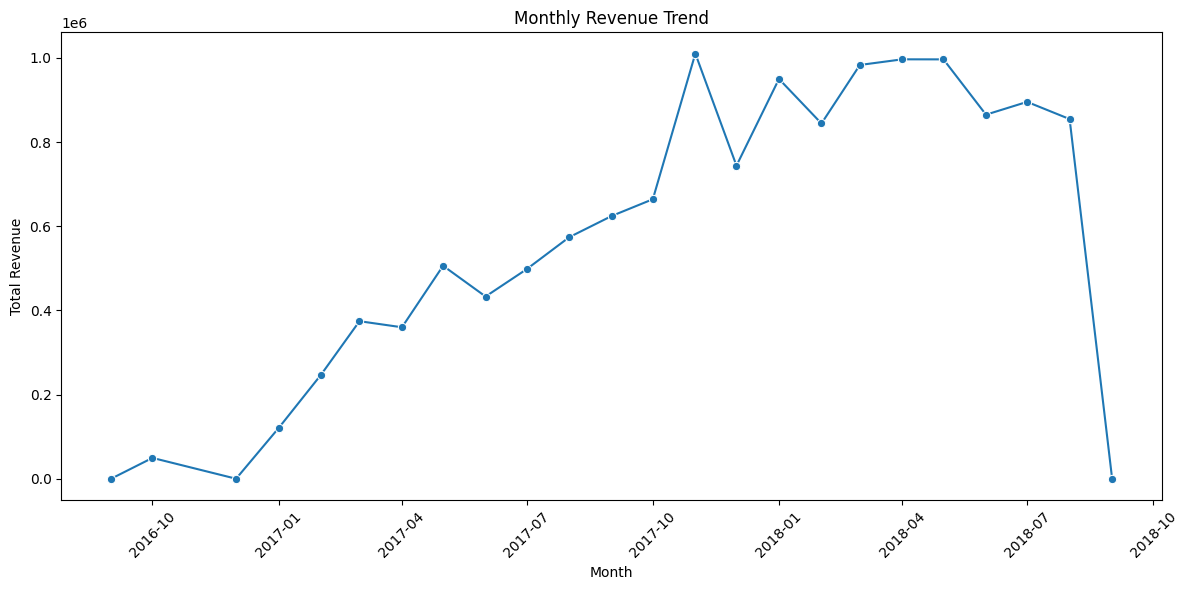

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_revenue,
    x='order_month',
    y='total_revenue',
    marker='o'
)

plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Q: What is the total revenue?
Q: How does revenue trend monthly
A: The total revenue over the entire period is $13.6M, with a steady increase from Oct 2016 to Nov 2017, averaging ~$0.6M, and continues to hover around $0.8M/month thereafter

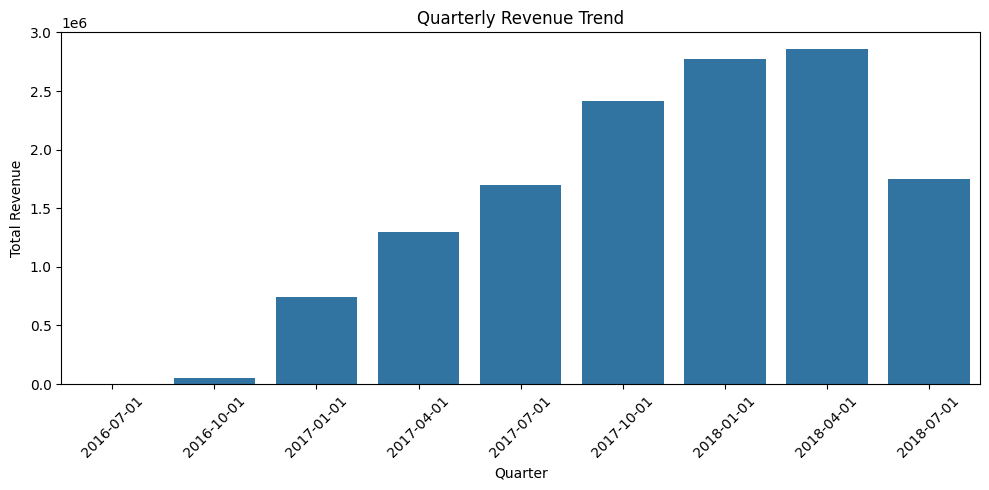

In [33]:
# Add order_quarter column
order_items_with_time['order_quarter'] = order_items_with_time['order_purchase_timestamp'].dt.to_period('Q')

# Aggregate total revenue by quarter
quarterly_revenue = (
    order_items_with_time
    .groupby('order_quarter')['price']
    .sum()
    .reset_index(name='total_revenue')
)

# Convert period to timestamp if needed for plotting
quarterly_revenue['order_quarter_start'] = quarterly_revenue['order_quarter'].dt.start_time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(
    data=quarterly_revenue,
    x='order_quarter_start',
    y='total_revenue',
)
plt.title("Quarterly Revenue Trend")
plt.xlabel("Quarter")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Q: How does revenue trend quarterly?
A: There is no noticable seasonal trend, but revenue has been steadily increasing by ~$0.4M per quarter, with the exception of 2018 Q3, which shows a temporary drop, likely due to incomplete data.

In [34]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [36]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [35]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [42]:
orders_by_state = orders.merge(
    customers[['customer_id', 'customer_state']],
    on='customer_id',
    how='left'
)
orders_by_state_price = orders_by_state.merge(
    order_items[['order_id', 'price']],
    on='order_id',
    how='left'
)
# Group by state and aggregate both metrics
state_summary = (
    orders_by_state_price
    .groupby('customer_state')
    .agg(
        num_orders=('order_id', 'nunique'),  # count unique orders
        total_revenue=('price', 'sum')       # sum of price
    )
    .reset_index()
)
state_summary['revenue/order'] = state_summary['total_revenue']/state_summary['num_orders']
state_summary.head()

,customer_state,num_orders,total_revenue,revenue/order
0,AC,81,15982.95,197.320370
1,AL,413,80314.81,194.466852
2,AM,148,22356.84,151.059730
3,AP,68,13474.30,198.151471
4,BA,3380,511349.99,151.286979


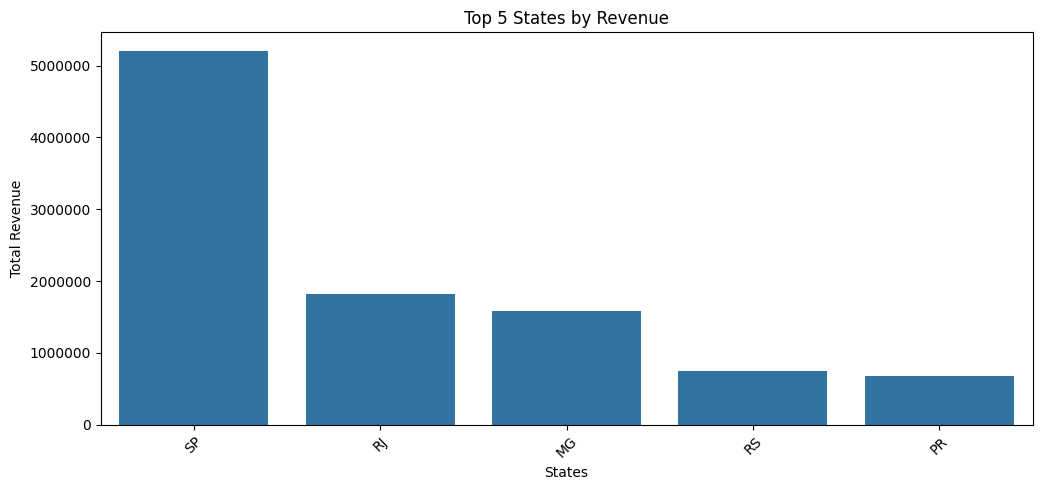

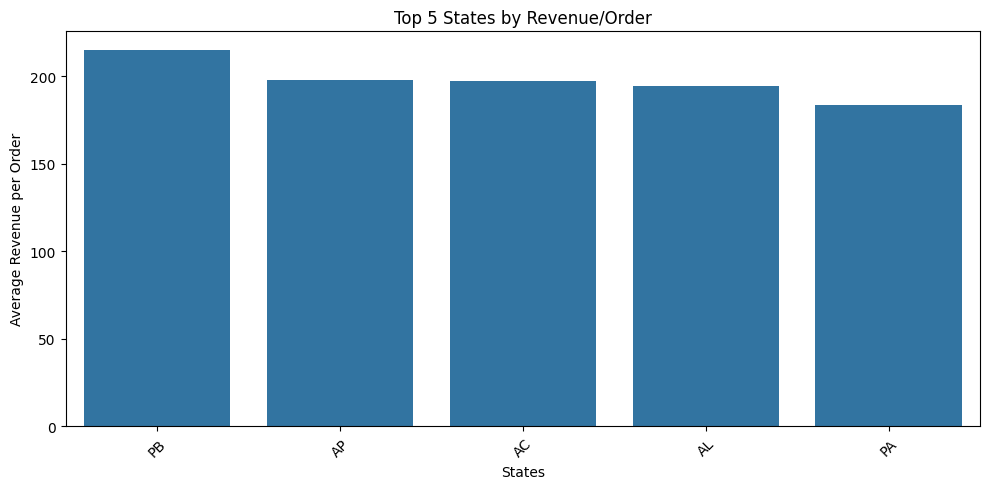

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(
    data=state_summary.sort_values(by='total_revenue', ascending=False).head(5), #Top 5 state by total revenue
    x='customer_state',
    y='total_revenue',
)
plt.title("Top 5 States by Revenue")
plt.xlabel("States")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(
    data=state_summary.sort_values(by='revenue/order', ascending=False).head(5), #Top 5 state by total revenue
    x='customer_state',
    y='revenue/order',
)
plt.title("Top 5 States by Revenue/Order")
plt.xlabel("States")
plt.ylabel("Average Revenue per Order")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
# Sum total revenue and total orders across all states
total_revenue = state_summary['total_revenue'].sum()
total_orders = state_summary['num_orders'].sum()

# Compute average revenue per order
avg_revenue_per_order = total_revenue / total_orders

print(f"Average revenue per order: ${avg_revenue_per_order:,.2f}")

Average revenue per order: $136.68


Q: Which states bring in the most revenue?
A: SP brings in the most revenue at ~$5M, followed by RJ at ~$1.7M and MG at ~$1.5M.
Q: Which states bring in the most revenue/order?
A: PB brings in the most revenue/order at ~$210, followed by AP at ~$200 with AC close behind.
Q: What is the avg revenue/order?
A: The average revenue per order is $136.68 across all purchases.

In [51]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [52]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [53]:
category_english.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [55]:
category_revenue = order_items.merge(
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)
category_revenue_english = category_revenue.merge(
    category_english[['product_category_name','product_category_name_english']],
    on='product_category_name',
    how='left'
)
category_revenue_summary = (
    category_revenue_english
    .groupby('product_category_name_english')
    .agg(
        num_orders=('order_id', 'nunique'),  # count unique orders
        total_revenue=('price', 'sum')       # sum of price
    )
    .reset_index()
)
category_revenue_summary.head()

,product_category_name_english,num_orders,total_revenue
0,agro_industry_and_commerce,182,72530.47
1,air_conditioning,253,55024.96
2,art,202,24202.64
3,arts_and_craftmanship,23,1814.01
4,audio,350,50688.50


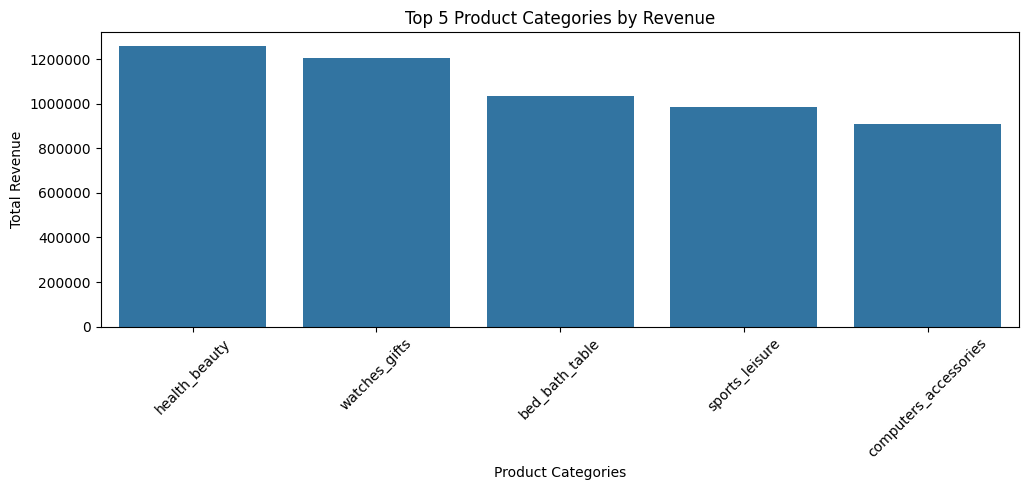

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(
    category_revenue_summary.sort_values(by='total_revenue', ascending=False).head(5), #Top 5 state by total revenue
    x='product_category_name_english',
    y='total_revenue',
)
plt.title("Top 5 Product Categories by Revenue")
plt.xlabel("Product Categories")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

Q: Which product categories bring in the most revenue?
A: Health and Beauty brings in the most at ~$1.22M, followed by Watches and Gifts at ~$1.2M and Bed, Bath, Table at ~$1M

In [ ]:
import math
order_item_summary = (
    order_items
    .groupby('product_id')
    .agg(
        num_orders=('order_id', 'nunique'),  # count unique orders
        total_revenue=('price', 'sum')       # sum of price
    )
    .reset_index()
)
top_10_percent = math.floor(len(order_item_summary) * 0.1)
order_item_summary_top_10 = order_item_summary.sort_values(by='total_revenue', ascending=False).head(top_10_percent)
total_top10_revenue_percent = order_item_summary_top_10['total_revenue'].sum()/total_revenue*100
order_item_summary_top_10.head(5)

,product_id,num_orders,total_revenue
24086,bb50f2e236e5eea0100680137654686c,187,63885.00
14068,6cdd53843498f92890544667809f1595,151,54730.20
27613,d6160fb7873f184099d9bc95e30376af,35,48899.34
27039,d1c427060a0f73f6b889a5c7c61f2ac4,323,47214.51
19742,99a4788cb24856965c36a24e339b6058,467,43025.56


In [73]:
print(total_top10_revenue_percent)

60.839627733914185


Q: What % of revenue comes from the top 10% of products?
A: 61% of revenue comes from the top 10% of products, with product_id bb50f2e236e5eea0100680137654686c contributing the most, $63.9k. (No product name available)

In [74]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [75]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [76]:
order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [78]:
top_10_states = state_summary.sort_values('total_revenue', ascending=False).head(10)
orders_top_states = orders.merge(
    customers[['customer_id','customer_state']], 
    on='customer_id', 
    how='left'
)
orders_top_states = orders_top_states[orders_top_states['customer_state'].isin(top_10_states['customer_state'])]

In [79]:
orders_items_top = orders_top_states.merge(
    order_items[['order_id','product_id']], 
    on='order_id', 
    how='left'
).merge(
    products[['product_id','product_category_name']], 
    on='product_id', 
    how='left'
)

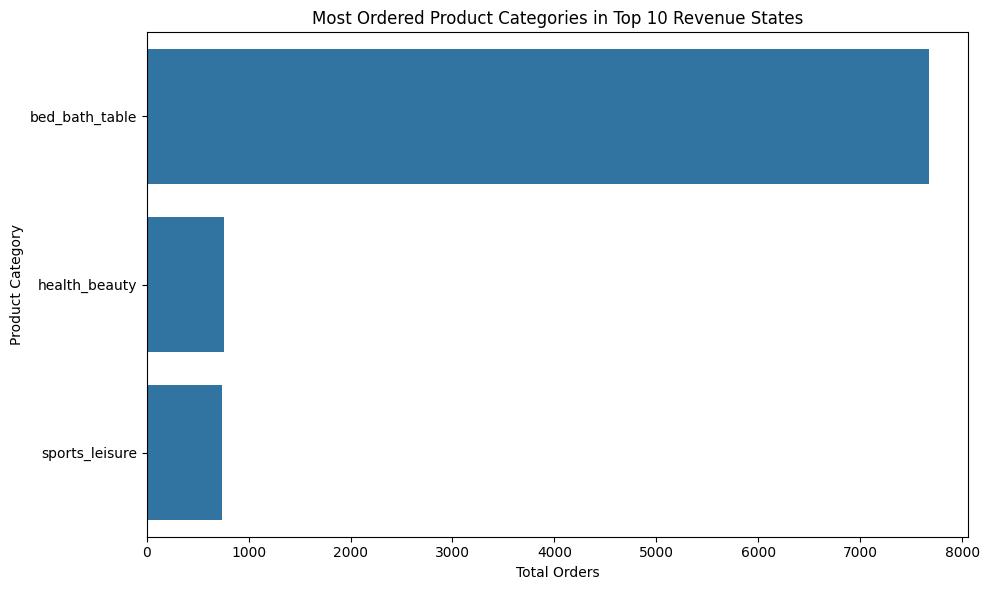

In [87]:
category_by_state = (
    orders_items_top
    .groupby(['customer_state','product_category_name'])
    .agg(num_orders=('order_id','nunique'))
    .reset_index()
)

# Get the most ordered category per state
most_ordered_category = category_by_state.loc[category_by_state.groupby('customer_state')['num_orders'].idxmax()]
most_ordered_category_english = most_ordered_category.merge(
    category_english[['product_category_name','product_category_name_english']], 
    on='product_category_name', 
    how='left'
)

# Sum the number of orders for each top category across states
category_order_sums = (
    most_ordered_category_english
    .groupby('product_category_name_english')
    .agg(total_num_orders=('num_orders', 'sum'))
    .reset_index()
    .sort_values(by='total_num_orders', ascending=False)
)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top categories by total orders
plt.figure(figsize=(10,6))
sns.barplot(
    data=category_order_sums,          # DataFrame from previous step
    x='total_num_orders',              # Total orders
    y='product_category_name_english',# Category names
)

plt.title("Most Ordered Product Categories in Top 10 Revenue States")
plt.xlabel("Total Orders")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

Q: What is the most ordered category in the top 10 states by revenue?
A: Across the top 10 states, Bed,Bath and Table is the most ordered at 7.6k orders, followed by Health and Beauty, and Sports and Leisure at 760 and 743 respectively.

--Customer KPIs--
How many unique customers are there?
Which states have the highest customer concentration?
What % of customers are repeat buyers?
Do repeat buyers spend more than one-time buyers?
What is the average time between each purchase?


--Delivery & Operations--
What is the average delivery time?
What % of orders are delivered on time / early / late?
How late are late deliveries?
Which states have the worst delays?
Is there any relationship between delivery delay and review scores?

--Customer Satisfaction--
What is the average review score?
Does late delivery reduce review scores?
Do certain categories get systematically worse reviews?
Does faster review response time improve ratings?

--Product & Category Performance--
Which products sell the most units?
Which categories have high volume but low revenue?
What % of products generate 80% of sales?

--Payment & Risk--
What payment methods are most common?
Do certain payment methods have higher order values?
Do installment orders get worse reviews?
Does payment type affect delivery speed?

Revenue & Product
Delivery & Operations
Customer Satisfaction